In [119]:
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [120]:
# pcap to dataframe

pcap = rdpcap("../pcaps/webinar_pcap_compressed_6.pcap")

ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    field_values = []
    for field in ip_fields:
        if field == 'options':
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# replace proto values with strings 'tcp' or 'udp'

#df['proto'] = df['proto'].replace([6],'tcp')
#df['proto'] = df['proto'].replace([17],'udp')

df = df.reset_index()
df["len"] = pd.to_numeric(df["len"])
df["time"] = pd.to_numeric(df["len"])

df = df.drop(columns="index")

proto
6     53
17     5
Name: src, dtype: int64


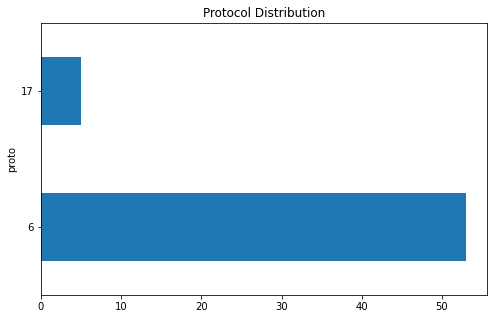

In [121]:
protocol_stats = df.groupby("proto")['src'].count()
print(protocol_stats)
protocol_stats.plot(kind='barh',title="Protocol Distribution",figsize=(8,5))
plt.show()




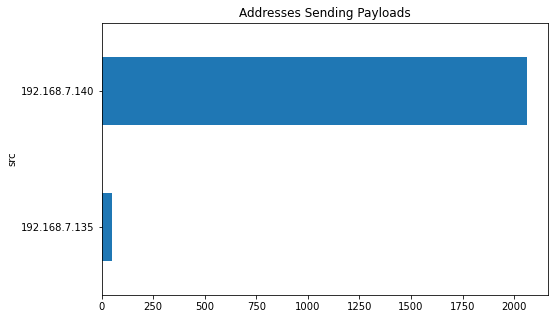

In [122]:
# Graph - Group by Source Address and Payload Sum

source_addresses = df.groupby("src")['payload'].sum()
source_addresses.plot(kind='barh',title="Addresses Sending Payloads",figsize=(8,5))
plt.show()


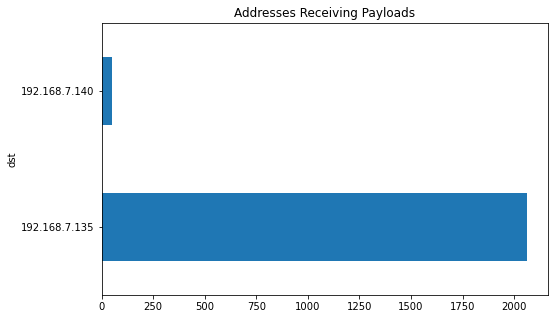

In [123]:
# Graph - Group by Dest Address and Payload Sum

dst_addresses = df.groupby("dst")['payload'].sum()
dst_addresses.plot(kind='barh',title="Addresses Receiving Payloads",figsize=(8,5))
plt.show()


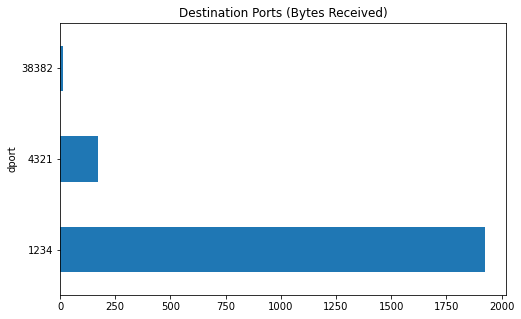

In [124]:
# Graph - Group by Destination Port and Payload Sum

destination_ports = df.groupby("dport")['payload'].sum()
destination_ports.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))
plt.show()


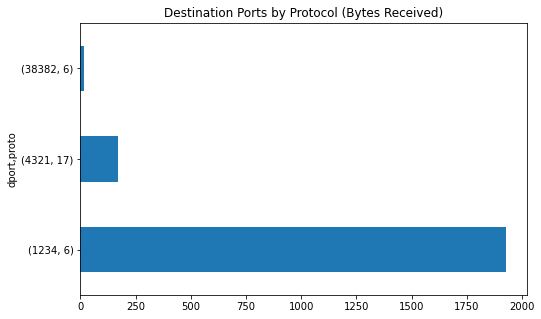

In [125]:
# Graph - Group by Destination Port, Protocol and Payload Sum

destination_payloads_proto = df.groupby(["dport","proto"])['payload'].sum()
destination_payloads_proto.plot(kind='barh',title="Destination Ports by Protocol (Bytes Received)",figsize=(8,5))
plt.show()


In [126]:

# Adding human-readable timestamp column

def return_timestamp(x):
    return datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f')

df['timestamp'] = df['time'].apply(lambda x: (return_timestamp(x)))
df['timestamp'] = pd.to_datetime(df['timestamp'])



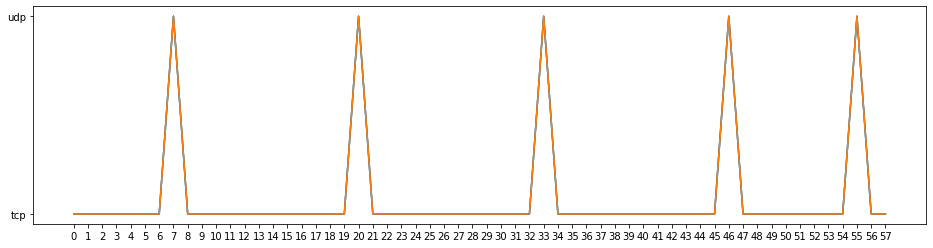

In [127]:
df['proto'].plot(figsize=(16,4))
df['proto'].plot(subplots=True, figsize=(16,4))
df['proto'].plot(y=["proto"], figsize=(16,4))
plt.xticks(df.index)
plt.yticks([6,17],['tcp','udp'])
plt.show()

# Notice the heartbeat packet
# Negotiation changes across runs
# Show this graph for the 3 pcaps

In [128]:
# Visualization across 3 pcaps - helps to see what the fields are


In [129]:
# UDP length statistics
df[df['proto'] == 17].describe()


,len,time
count,5.000000,5.000000
mean,62.400000,62.400000
std,0.894427,0.894427
min,62.000000,62.000000
25%,62.000000,62.000000
50%,62.000000,62.000000
75%,62.000000,62.000000
max,64.000000,64.000000


In [130]:
# TCP length statistics
df[df['proto'] == 6].describe()


,len,time
count,53.000000,53.000000
mean,88.924528,88.924528
std,43.608772,43.608772
min,52.000000,52.000000
25%,52.000000,52.000000
50%,52.000000,52.000000
75%,142.000000,142.000000
max,142.000000,142.000000


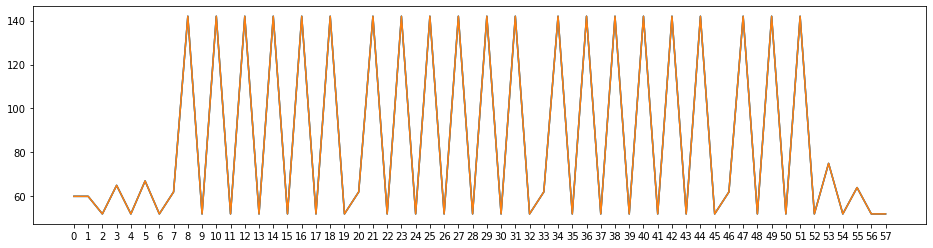

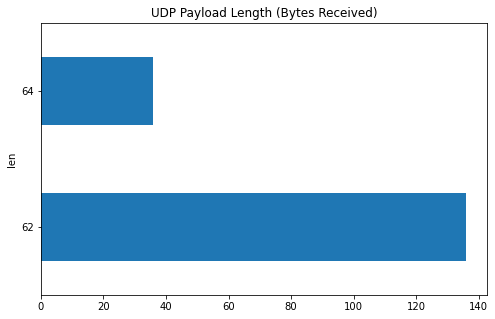

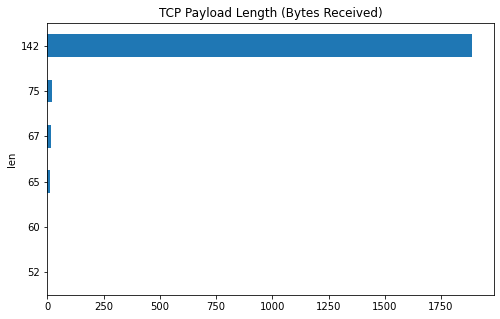

In [131]:
# Packet length visualizations

df['len'].plot(figsize=(16,4))
df['len'].plot(subplots=True, figsize=(16,4))
df['len'].plot(y=['len'], figsize=(16,4))
plt.xticks(df.index)
plt.show()

# UDP length 

udp_df = df[df['proto'] == 17]
destination_ports = udp_df.groupby("len")['payload'].sum()
destination_ports.plot(kind='barh',title="UDP Payload Length (Bytes Received)",figsize=(8,5))
plt.show()

# TCP length

udp_df = df[df['proto'] == 6]
destination_ports = udp_df.groupby("len")['payload'].sum()
destination_ports.plot(kind='barh',title="TCP Payload Length (Bytes Received)",figsize=(8,5))
plt.show()

# TCP segment size by IP address

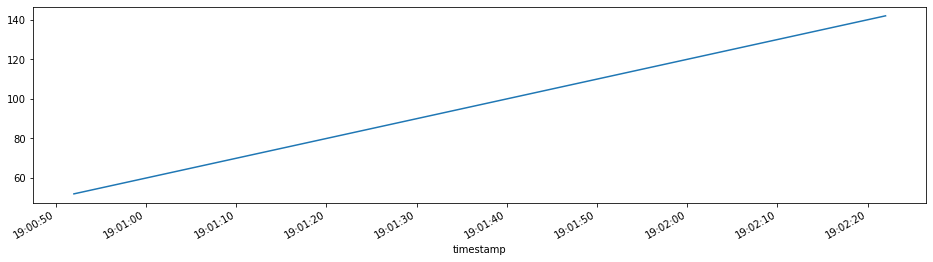

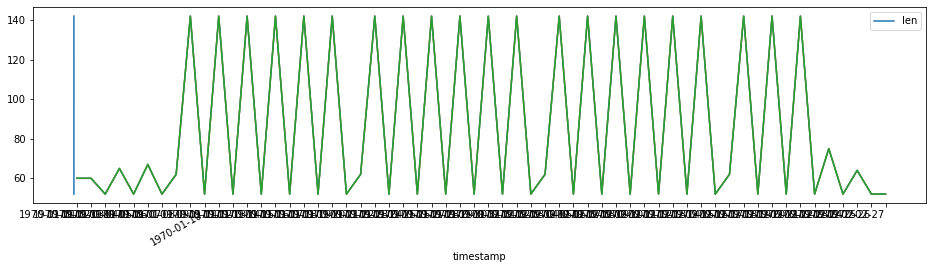

In [132]:
# Create a new index by timestamp 

df_indexed = df.set_index('timestamp')
df_indexed['len'].plot(figsize=(16,4))
df_indexed.plot(y='len')

df['len'].plot(figsize=(16,4))
df['len'].plot(subplots=True, figsize=(16,4))
df['len'].plot(y=['len'], figsize=(16,4))
plt.xticks(df.index)
plt.show()




In [133]:
# Geocoordinates from several pcaps - payload


In [134]:
# Search IP in payload - visualization



In [219]:
# Splitting the payload column into sets of two characters, and add them to new column

def return_list_of_bytes(x,n):
    return [x[index : index + n] for index in range(0, len(x), n)]

df['payload_array'] = df['payload_hex'].apply(lambda x: return_list_of_bytes(x,8))

df['payload_array'].iloc[10][0]

b'c0a8078c'